In [1]:

# Cell 1: Import Libraries  
import torch  
import torch.nn as nn  
import torch.optim as optim  
from torch.utils.data import DataLoader  
from torchvision import datasets, transforms  
import numpy as np  
import matplotlib.pyplot as plt  

DATA_PATH = r"D:\data\data original"  
OUTPUT_DIR = r"D:\data mining\appendix"  
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'  

print(f"Device: {DEVICE}")  


Device: cpu


In [2]:

# Cell 2: Define Autoencoder Architecture  
class ConvAutoencoder(nn.Module):  
    def __init__(self, latent_dim=512):  
        super(ConvAutoencoder, self).__init__()  
        
        # Encoder  
        self.encoder = nn.Sequential(  
            nn.Conv2d(3, 32, 4, stride=2, padding=1),   # 112x112  
            nn.BatchNorm2d(32),  
            nn.ReLU(),  
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # 56x56  
            nn.BatchNorm2d(64),  
            nn.ReLU(),  
            nn.Conv2d(64, 128, 4, stride=2, padding=1), # 28x28  
            nn.BatchNorm2d(128),  
            nn.ReLU(),  
            nn.Conv2d(128, 256, 4, stride=2, padding=1),# 14x14  
            nn.BatchNorm2d(256),  
            nn.ReLU(),  
            nn.Flatten(),  
            nn.Linear(256 * 14 * 14, latent_dim)  
        )  
        
        # Decoder  
        self.decoder = nn.Sequential(  
            nn.Linear(latent_dim, 256 * 14 * 14),  
            nn.ReLU(),  
            nn.Unflatten(1, (256, 14, 14)),  
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),  
            nn.BatchNorm2d(128),  
            nn.ReLU(),  
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  
            nn.BatchNorm2d(64),  
            nn.ReLU(),  
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  
            nn.BatchNorm2d(32),  
            nn.ReLU(),  
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),  
            nn.Sigmoid()  
        )  
    
    def forward(self, x):  
        latent = self.encoder(x)  
        reconstructed = self.decoder(latent)  
        return latent, reconstructed  
    
    def get_latent(self, x):  
        return self.encoder(x)  

model = ConvAutoencoder(latent_dim=512).to(DEVICE)  
print(f"Autoencoder created with {sum(p.numel() for p in model.parameters())} parameters")  


Autoencoder created with 52812355 parameters


In [3]:

# Cell 3: Prepare Data  
transform_ae = transforms.Compose([  
    transforms.Resize((224, 224)),  
    transforms.ToTensor()  
])  

dataset = datasets.ImageFolder(root=DATA_PATH, transform=transform_ae)  
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)  

print(f"Dataset size: {len(dataset)}")  

Dataset size: 2527


Training autoencoder...
Epoch [10/20], Loss: 0.0082
Epoch [20/20], Loss: 0.0055


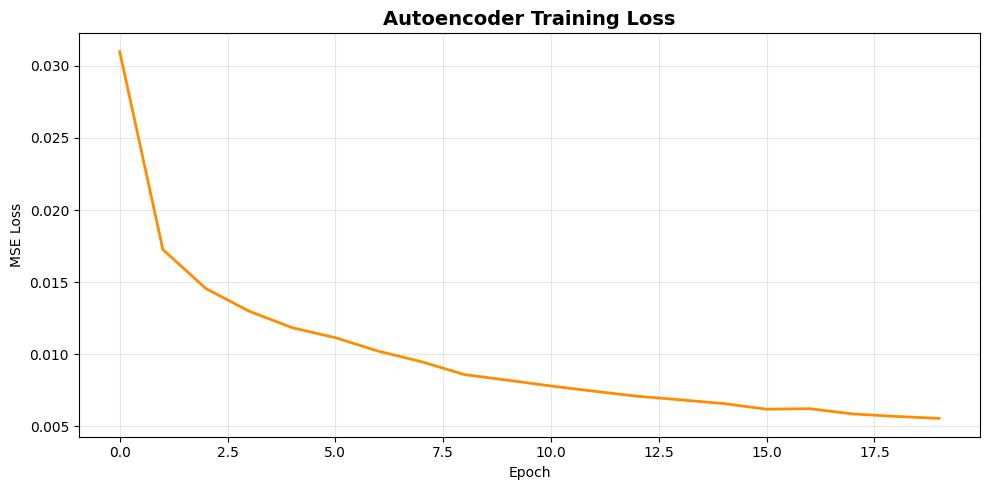

Model saved


In [4]:

# Cell 4: Train Autoencoder  
EPOCHS =20 
LR = 1e-3  

optimizer = optim.Adam(model.parameters(), lr=LR)  
criterion = nn.MSELoss()  

losses = []  

print("Training autoencoder...")  

for epoch in range(EPOCHS):  
    epoch_loss = 0  
    for imgs, _ in dataloader:  
        imgs = imgs.to(DEVICE)  
        
        optimizer.zero_grad()  
        latent, reconstructed = model(imgs)  
        loss = criterion(reconstructed, imgs)  
        loss.backward()  
        optimizer.step()  
        
        epoch_loss += loss.item()  
    
    avg_loss = epoch_loss / len(dataloader)  
    losses.append(avg_loss)  
    
    if (epoch + 1) % 10 == 0:  
        print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}')  

plt.figure(figsize=(10, 5))  
plt.plot(losses, linewidth=2, color='darkorange')  
plt.title('Autoencoder Training Loss', fontsize=14, fontweight='bold')  
plt.xlabel('Epoch')  
plt.ylabel('MSE Loss')  
plt.grid(alpha=0.3)  
plt.tight_layout()  
plt.savefig(f'{OUTPUT_DIR}/08_autoencoder_training.png', dpi=300, bbox_inches='tight')  
plt.show()  

torch.save(model.state_dict(), f'{OUTPUT_DIR}/autoencoder_model.pth')  
print("Model saved")  


In [5]:

# Cell 5: Extract Autoencoder Features  
model.eval()  
ae_features = []  
ae_labels = []  

print("Extracting autoencoder features...")  

with torch.no_grad():  
    for imgs, lbls in dataloader:  
        imgs = imgs.to(DEVICE)  
        latent = model.get_latent(imgs)  
        ae_features.append(latent.cpu().numpy())  
        ae_labels.append(lbls.numpy())  

ae_features = np.vstack(ae_features)  
ae_labels = np.concatenate(ae_labels)  

print(f"Autoencoder features: {ae_features.shape}")  

np.save(f'{OUTPUT_DIR}/autoencoder_features.npy', ae_features)  
np.save(f'{OUTPUT_DIR}/autoencoder_labels.npy', ae_labels)  


Extracting autoencoder features...
Autoencoder features: (2527, 512)


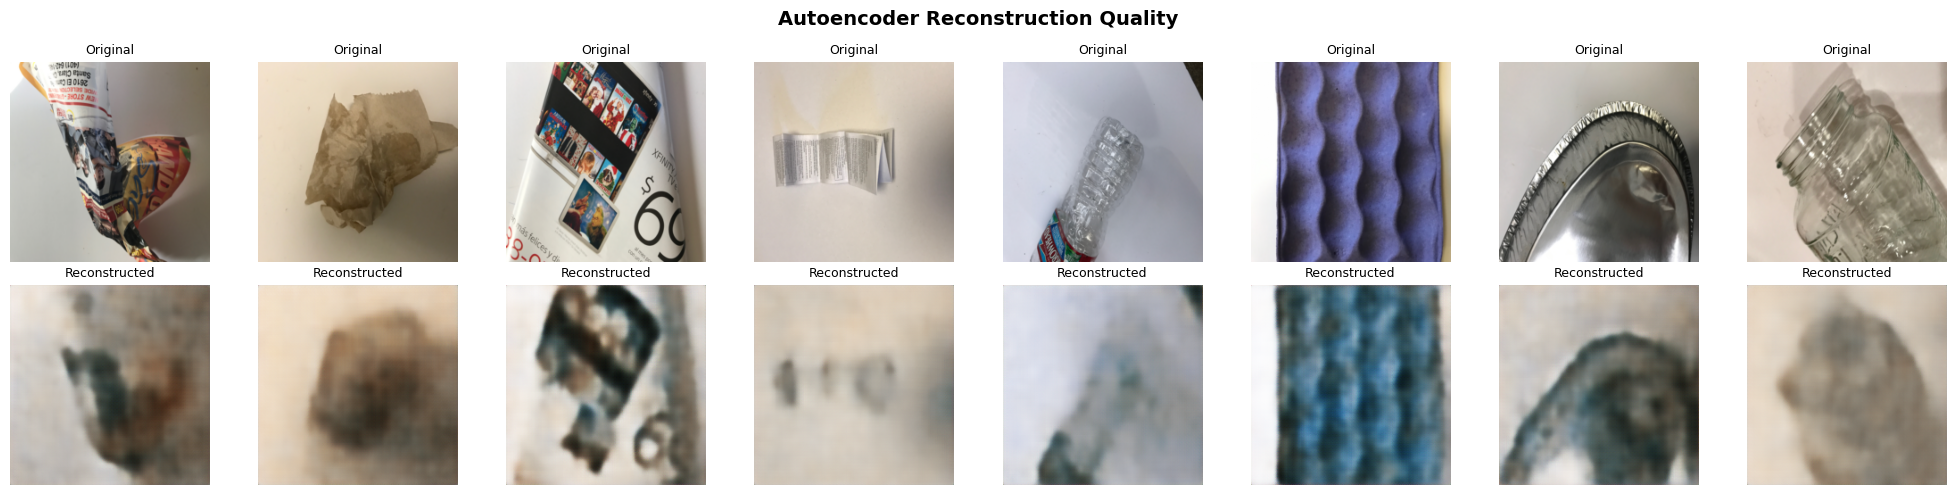

In [6]:

# Cell 6: Visualize Reconstruction  
dataloader_test = DataLoader(dataset, batch_size=8, shuffle=True)  
test_imgs, _ = next(iter(dataloader_test))  
test_imgs = test_imgs.to(DEVICE)  

with torch.no_grad():  
    _, reconstructed = model(test_imgs)  

fig, axes = plt.subplots(2, 8, figsize=(20, 5))  

for i in range(8):  
    axes[0, i].imshow(test_imgs[i].cpu().permute(1, 2, 0))  
    axes[0, i].set_title('Original', fontsize=9)  
    axes[0, i].axis('off')  
    
    axes[1, i].imshow(reconstructed[i].cpu().permute(1, 2, 0))  
    axes[1, i].set_title('Reconstructed', fontsize=9)  
    axes[1, i].axis('off')  

plt.suptitle('Autoencoder Reconstruction Quality', fontsize=14, fontweight='bold')  
plt.tight_layout()  
plt.savefig(f'{OUTPUT_DIR}/08_reconstruction_quality.png', dpi=300, bbox_inches='tight')  
plt.show()  


Loaded: (2527, 512) (2527,)


C:\Users\倪晗骏\dml_env\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP embedding: (2527, 2)


C:\Users\倪晗骏\AppData\Local\Temp\ipykernel_36372\118388901.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(class_names))


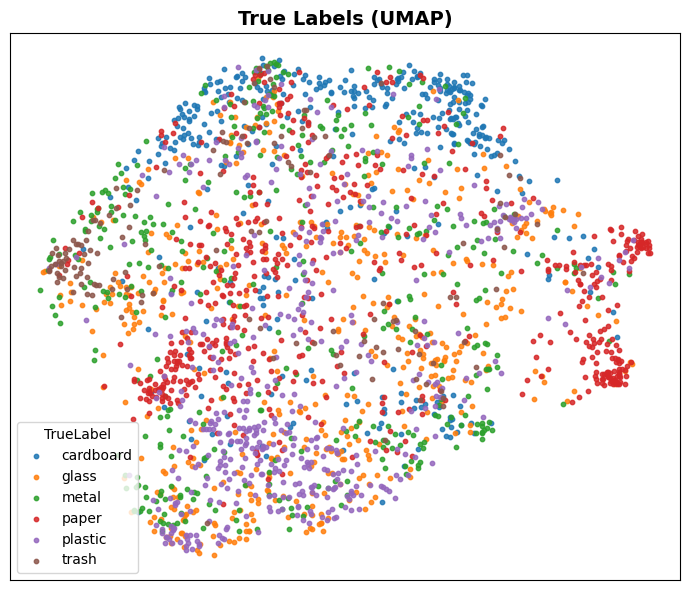

Saved: D:\data mining\appendix\09_umap_true_labels_autoencoder.png


In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt

# 1) Load saved AE features/labels (or use in-memory ae_features/ae_labels)
feat_path = os.path.join(OUTPUT_DIR, "autoencoder_features.npy")
lab_path  = os.path.join(OUTPUT_DIR, "autoencoder_labels.npy")

ae_features = np.load(feat_path)   # shape: [N, latent_dim]
ae_labels   = np.load(lab_path)    # shape: [N,]

print("Loaded:", ae_features.shape, ae_labels.shape)


import umap

reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric="euclidean",
    random_state=42
)

umap_emb = reducer.fit_transform(ae_features)  # shape: [N, 2]
print("UMAP embedding:", umap_emb.shape)

# 3) Plot (True labels)
plt.figure(figsize=(7, 6))


cmap = plt.cm.get_cmap("tab10", len(class_names))

for k, name in enumerate(class_names):
    idx = (ae_labels == k)
    plt.scatter(
        umap_emb[idx, 0], umap_emb[idx, 1],
        s=10, alpha=0.85, label=name
    )

plt.title("True Labels (UMAP)", fontsize=14, fontweight="bold")
plt.xticks([])
plt.yticks([])
plt.legend(title="TrueLabel", loc="lower left", frameon=True)
plt.tight_layout()

out_path = os.path.join(OUTPUT_DIR, "09_umap_true_labels_autoencoder.png")
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", out_path)